## Mountain Car

we are going to help the car to reach the goal with fuzzy control
https://github.com/openai/gym/wiki/MountainCarContinuous-v0

import modules :

In [1]:
%matplotlib notebook
import gym
import sys
import numpy as np
import skfuzzy as fuzzy
from skfuzzy import control as ctrl

init environment

In [2]:
env = gym.make('MountainCarContinuous-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/hadi/Documents/python/venv/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### making linguistic variables
according to action space and obserbation space, we determine linguistic vars.
we choose distance between every point as 0.02 (step = 0.02)

In [3]:
step = 0.02
position = ctrl.Antecedent(np.arange(-1.2, 0.6 + step, step), 'position')
velocity = ctrl.Antecedent(np.arange(-0.07, 0.07, step), 'velocity')
force = ctrl.Consequent(np.arange(-1, 1 + step, step), 'force')

In [4]:
print(position.universe.min() , position.universe.max())
print(velocity.universe.min() , velocity.universe.max())
print(force.universe.min() , force.universe.max())


-1.2 0.6000000000000016
-0.07 0.07
-1.0 1.0000000000000018


make membership functions:

In [5]:
position['negative'] = fuzzy.trimf(position.universe, [-1.2,-1.2,0.0])
position['zero'] = fuzzy.trimf(position.universe, [-0.2,0.0,0.2])
position['positive'] = fuzzy.trimf(position.universe, [0.0, 0.6, 0.6])

In [6]:
velocity.automf(3, names=['negative','zero', 'positive'])

In [7]:
force.automf(5, names=['v_negative', 'l_negative', 'zero', 'l_positive', 'v_positive'])

<IPython.core.display.Javascript object>


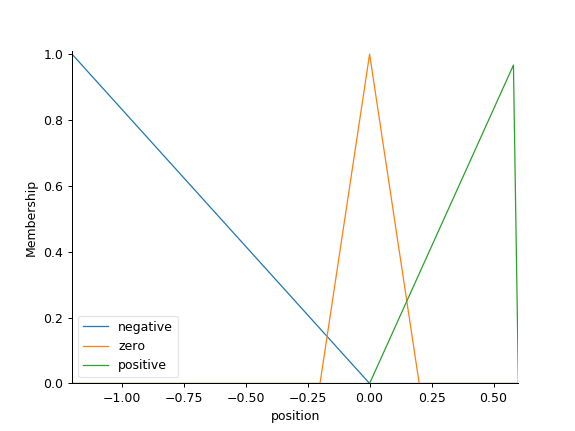

In [8]:
position.view()

<IPython.core.display.Javascript object>


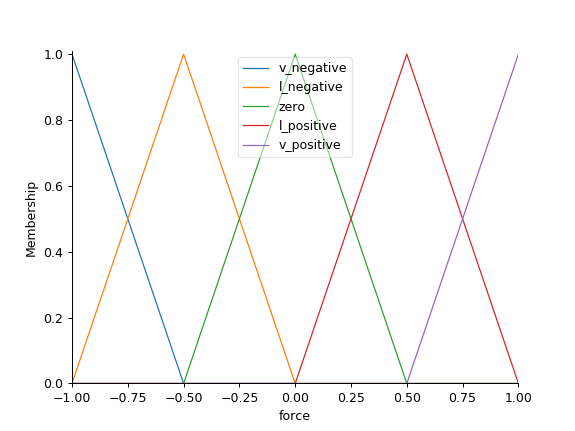

In [9]:
force.view()

### make rules

In [10]:
rule_1 = ctrl.Rule(position['negative'] & velocity['negative'], force['v_negative'])
rule_2 = ctrl.Rule(position['negative'] & velocity['positive'], force['v_positive'])
rule_3 = ctrl.Rule(position['positive'] & velocity['positive'], force['v_positive'])
rule_4 = ctrl.Rule(position['positive'] & velocity['negative'], force['v_negative'])
rule_5 = ctrl.Rule(position['zero'] & velocity['negative'], force['v_negative'])
rule_6 = ctrl.Rule(position['zero'] & velocity['positive'], force['v_positive'])

## simple rule
rule_s1 = ctrl.Rule(velocity['negative'], force['v_negative'])
rule_s2 = ctrl.Rule(velocity['positive'], force['v_positive'])

### make conroller and simulation

In [11]:
car_ctrl = ctrl.ControlSystem([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6])
car_sim = ctrl.ControlSystemSimulation(car_ctrl)

make other controler with simplified rules:

In [12]:
car_simple_ctrl = ctrl.ControlSystem([rule_s1, rule_s2])
car_simple_sim = ctrl.ControlSystemSimulation(car_simple_ctrl)

#### simulate environment with complicated rules :

In [13]:
action = env.action_space.sample()
for i_episode in range(20):
    observation = env.reset()
    done = False
    while not done:
        try:
            env.render()
#             print(f'action {action}')
            observation, reward, done, info = env.step(action)
            car_sim.input['position'] = observation[0]
            car_sim.input['velocity'] = observation[1]
            car_sim.compute()
            action = [car_sim.output['force']]
#             action = env.action_space.sample()
        except KeyboardInterrupt:
            env.close()
            break
    else:
        continue
    break
        

#### simulate environment with simplified rules :

In [14]:
action = env.action_space.sample()
for i_episode in range(20):
    observation = env.reset()
    done = False
    while not done:
        try:
            env.render()
#             print(f'action {action}')
            observation, reward, done, info = env.step(action)
#             car_simple_sim.input['position'] = observation[0]
            car_simple_sim.input['velocity'] = observation[1]
            car_simple_sim.compute()
            action = [car_simple_sim.output['force']]
#             action = env.action_space.sample()
        except KeyboardInterrupt:
            env.close()
            break
    else:
        continue
    break
        

as result, it seems that position can not help as input and velocity is sufficiant